生成的表面码电路:
      /------------------\ /-------------------------------------\ /-------------------\ /---------------------------------------------------------------------------------\ /---------------------------------------------------------------\ /-------------------------------------------------------------------------------------\ /-------------------\ /---------------------------------\ /REP 2   /-------------------------------------\ /-------------------\ /---------------------------------------------------------------------------------\ /---------------------------------------------------------------\ /-------------------------------------------------------------------------------------\ /-------------------\ /------------------------------------------------------------------------------\ \ /--------------------------------------------------------------------------------------------------------\
 q0: -------------------------------------------------------------------------------

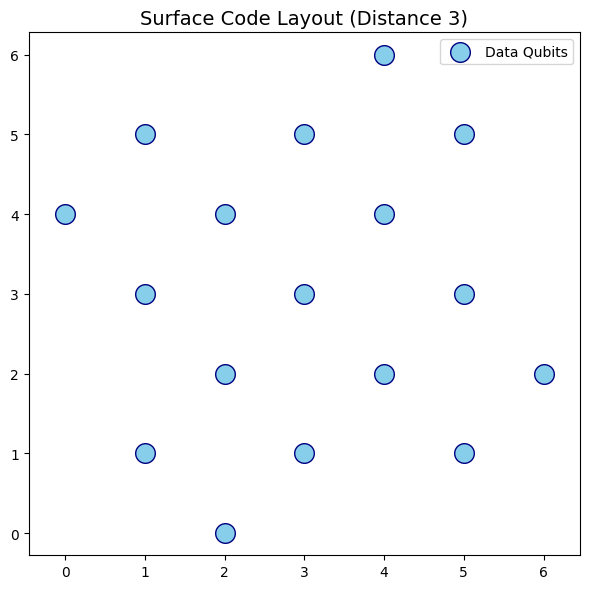

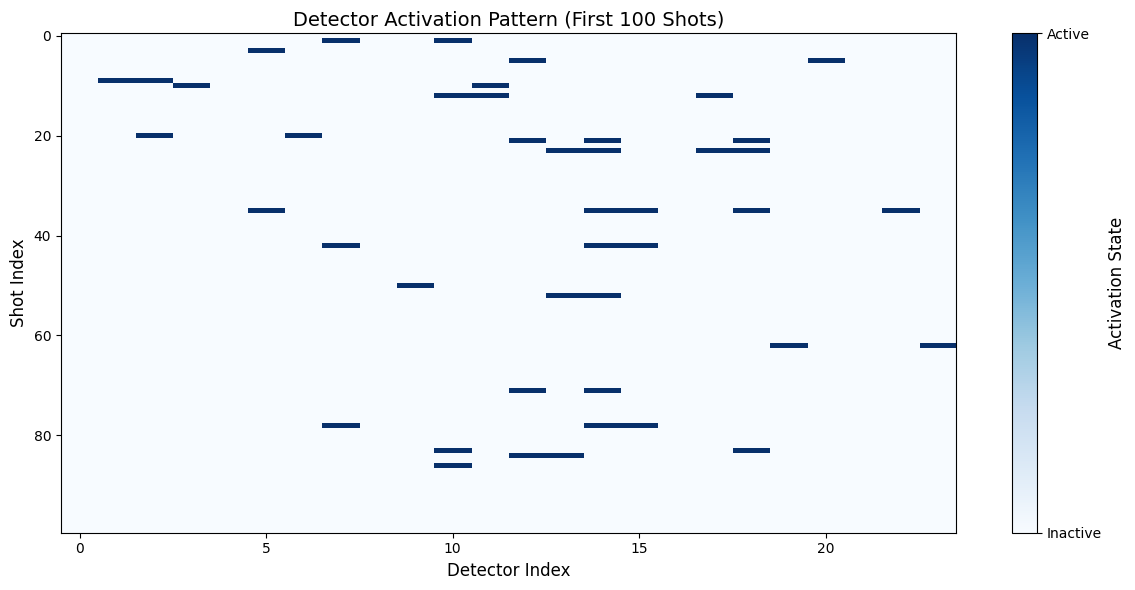


--- 可视化第 1 个shot的解码图 ---


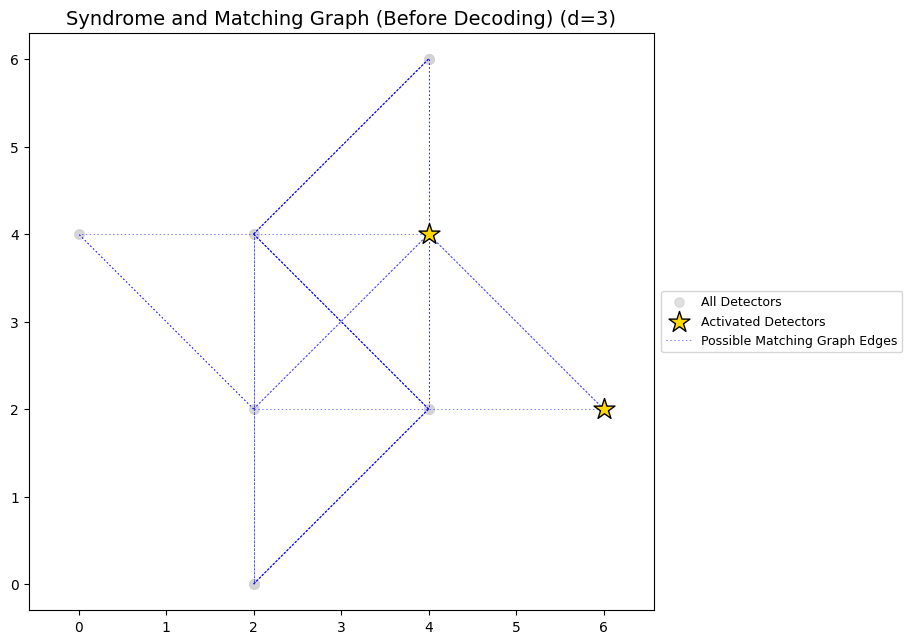

逻辑错误率 (d=3, shots=100000): 3.8500e-03


In [ ]:
import stim
import numpy as np
import matplotlib.pyplot as plt
from pymatching import Matching

# ======================
# 量子电路生成模块
# ======================

def create_surface_code_circuit(distance: int) -> stim.Circuit:
    """创建旋转表面码电路（含噪声模型）"""
    return stim.Circuit.generated(
        code_task="surface_code:rotated_memory_x",
        rounds=distance,
        distance=distance,
        after_clifford_depolarization=0.0028,
        before_round_data_depolarization=0.0028
    )

def sample_data_for_decoding(circuit: stim.Circuit, shots: int) -> tuple:
    """执行采样并返回可观测量翻转和探测器数据"""
    detector_sampler = circuit.compile_detector_sampler()
    _detection_events, _observable_flips = detector_sampler.sample(
        shots, separate_observables=True
    )
    return _observable_flips.astype(np.uint8), _detection_events.astype(np.uint8)

# ======================
# 可视化模块
# ======================

def plot_qubit_layout(circuit: stim.Circuit, current_distance: int):
    """可视化量子比特布局"""
    coords = circuit.get_final_qubit_coordinates()
    plt.figure(figsize=(6, 6))
    data_q = [k for k, (x_coord, y_coord) in coords.items() if (x_coord + y_coord) % 2 == 0]
    stab_q = [k for k, (x_coord, y_coord) in coords.items() if (x_coord + y_coord) % 2 == 1]

    if data_q:
        x_coords_data, y_coords_data = zip(*[coords[q] for q in data_q])
        plt.scatter(x_coords_data, y_coords_data, s=200, c='skyblue', edgecolors='navy', label='Data Qubits')
    if stab_q:
        x_coords_stab, y_coords_stab = zip(*[coords[q] for q in stab_q])
        plt.scatter(x_coords_stab, y_coords_stab, s=300, marker='s', facecolors='none',
                    edgecolors='crimson', linewidths=2, label='Stabilizers')

    plt.title(f"Surface Code Layout (Distance {current_distance})", fontsize=14)
    plt.axis('equal')
    plt.legend(loc='upper right') # 此处图例位置可以根据实际情况调整
    plt.tight_layout()
    plt.show()

def plot_detector_activity(detector_samples: np.ndarray):
    """检测器触发热图"""
    if detector_samples.shape[0] == 0:
        print("警告 (plot_detector_activity): detector_samples 为空，无法绘制热图。")
        return
    plt.figure(figsize=(12, 6))
    numeric_samples = detector_samples[:100].astype(int)
    plt.imshow(numeric_samples, cmap='Blues', aspect='auto',
               interpolation='nearest', vmin=0, vmax=1)
    plt.title("Detector Activation Pattern (First 100 Shots)", fontsize=14)
    plt.xlabel("Detector Index", fontsize=12)
    plt.ylabel("Shot Index", fontsize=12)
    cbar = plt.colorbar(ticks=[0, 1])
    cbar.ax.set_yticklabels(['Inactive', 'Active'], fontsize=10)
    cbar.set_label('Activation State', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_error_distribution(circuit: stim.Circuit, physical_samples: np.ndarray):
    coords = circuit.get_final_qubit_coordinates()
    qubit_indices_from_coords = sorted(coords.keys())
    if physical_samples.ndim == 1 :
        physical_samples = physical_samples.reshape(1, -1)
    if physical_samples.shape[0] == 0:
        print("警告 (plot_error_distribution): physical_samples 为空，无法绘制错误分布。")
        return
    num_measurements_in_circuit = physical_samples.shape[1]
    if num_measurements_in_circuit == 0:
        print("警告 (plot_error_distribution): 电路中没有测量，无法绘制错误分布。")
        return
    measurement_outcome_counts = np.sum(physical_samples, axis=0)
    plt.figure(figsize=(6, 6))
    max_count = np.max(measurement_outcome_counts) if measurement_outcome_counts.size > 0 else 1
    if max_count == 0: max_count = 1
    index_map = {q: idx for idx, q in enumerate(qubit_indices_from_coords)}
    for q_stim_idx, (x_coord, y_coord) in coords.items():
        mapped_idx = index_map.get(q_stim_idx)
        if mapped_idx is not None and (x_coord + y_coord) % 2 == 0:
            current_error_count = measurement_outcome_counts[min(mapped_idx, num_measurements_in_circuit-1)]
            size = 50 + 500 * (current_error_count / max_count)
            plt.scatter(x_coord, y_coord, s=size, c='red', alpha=0.6,
                        edgecolors='darkred', linewidth=0.5)
    plt.title("Physical Measurement '1' Outcome Frequency (Indirect)", fontsize=14)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


def plot_decoding_path(circuit: stim.Circuit, matching: Matching, shot_detector_sample: np.ndarray, current_distance: int):
    """
    解码路径可视化 (显示激活的探测器和整个匹配图，虚线样式已调整，图例位置调整)
    """
    dem = circuit.detector_error_model(decompose_errors=True)
    if dem is None:
        print("警告 (plot_decoding_path): 无法获取 DEM。")
        return

    detector_coords_with_t = dem.get_detector_coordinates()
    if not detector_coords_with_t:
        print("警告 (plot_decoding_path): DEM 不包含探测器坐标。")
        return

    detector_coords = {d: (x_coord, y_coord) for d, (x_coord, y_coord, t_coord) in detector_coords_with_t.items()}
    active_dets = np.where(shot_detector_sample.astype(bool))[0]

    fig_width = max(7.5, current_distance * 2)
    fig_height = max(7.5, current_distance * 2)
    plt.figure(figsize=(fig_width + 2.5, fig_height)) # 增加宽度以容纳图例

    if detector_coords:
        x_all, y_all = zip(*detector_coords.values())
        plt.scatter(x_all, y_all, s=45, c='lightgray', alpha=0.7, label='All Detectors', zorder=1)

    if len(active_dets) > 0 and detector_coords:
        active_coords_list = [detector_coords[d] for d in active_dets if d in detector_coords]
        if active_coords_list:
            x_act, y_act = zip(*active_coords_list)
            plt.scatter(x_act, y_act, s=250, marker='*', c='gold',
                        edgecolors='black', label='Activated Detectors', zorder=10)

    graph = matching.to_networkx()
    plotted_edge_label = False
    for (d1_idx, d2_idx) in graph.edges():
        coord1 = detector_coords.get(d1_idx)
        coord2 = detector_coords.get(d2_idx)
        
        if coord1 and coord2:
            x1, y1 = coord1
            x2, y2 = coord2
            label_text = 'Possible Matching Graph Edges' if not plotted_edge_label else "_nolegend_"
            plt.plot([x1, x2], [y1, y2],
                     color='blue',
                     linestyle=(0, (1.5, 2.5)),  # 更短的线段(1.5), 更长的间隔(2.5)
                     alpha=0.5,                 # 保持一定的可见度
                     linewidth=0.7,             # 可以尝试更细的线
                     label=label_text,
                     zorder=5)
            plotted_edge_label = True
    
    plt.title(f"Syndrome and Matching Graph (Before Decoding) (d={current_distance})", fontsize=14)
    plt.axis('equal')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        by_label = dict(zip(labels, handles))
        # 将图例放置在图像外部右侧中间位置
        plt.legend(by_label.values(), by_label.keys(), 
                   loc='center left', bbox_to_anchor=(1.01, 0.5), 
                   fontsize=9, borderaxespad=0.1)
    else:
        print("警告 (plot_decoding_path): 图例中没有可显示的内容。")
    
    # 调整子图参数以确保外部图例能完整显示
    plt.subplots_adjust(right=0.75) # 根据图例宽度可能需要调整这个值
    # plt.tight_layout() # tight_layout 可能与外部图例冲突，可尝试先注释掉或用subplots_adjust
    plt.show()

# ======================
# 主程序
# ======================

if __name__ == "__main__":
    distance = 3  # 建议使用 d=3 来测试虚线效果，因为图形相对不密集
    shots = 100000   # 减少次数以便快速看到绘图结果

    circuit = create_surface_code_circuit(distance)
    print("生成的表面码电路:")
    try:
        diagram_str = str(circuit.diagram("timeline-text"))
        print(diagram_str[:1500]) # 打印前1500字符
    except Exception as e:
        print(f"无法生成或打印电路图: {e}。\n电路前20条指令:")
        print(circuit[:20])

    plot_qubit_layout(circuit, distance)

    actual_observable_flips, detector_samples = sample_data_for_decoding(circuit, shots)

    dem = circuit.detector_error_model(decompose_errors=True)
    if dem is None :
        print("错误: 无法生成探测器错误模型 (DEM)。请检查电路和噪声设置。")
        exit()
    matching = Matching.from_detector_error_model(dem)

    if shots > 0:
        plot_detector_activity(detector_samples)

        if detector_samples.shape[0] > 0:
            example_idx = 0 
            for i in range(min(detector_samples.shape[0], 100)): # 最多检查前100个样本
                if np.any(detector_samples[i]):
                    example_idx = i
                    break
            if not np.any(detector_samples[example_idx]):
                 print(f"在选择的 {shots} 次采样中，第 {example_idx} 个样本没有探测器激活。")
            
            print(f"\n--- 可视化第 {example_idx} 个shot的解码图 ---")
            plot_decoding_path(circuit, matching, detector_samples[example_idx], distance)
        else:
            print("detector_samples 为空，跳过解码路径可视化。")
    else:
        print("采样次数为0，跳过部分可视化。")

    logical_error_rate = np.nan
    if shots > 0 and detector_samples.shape[0] > 0:
        predicted = matching.decode_batch(detector_samples)
        if predicted.shape[0] > 0 and actual_observable_flips.shape[0] > 0:
            if predicted.shape == actual_observable_flips.shape:
                num_errors = np.sum(np.any(predicted != actual_observable_flips, axis=1))
                logical_error_rate = num_errors / shots
            else:
                print(f"警告: predicted shape {predicted.shape}, actual_observable_flips shape {actual_observable_flips.shape}. LER计算可能需要调整。")
        elif shots > 0 :
             print(f"警告: 预测或实际观测数组为空（尽管shots > 0），无法计算逻辑错误率。 Predicted shape {predicted.shape}, Actual shape {actual_observable_flips.shape}")
    else:
        print("采样次数为0或detector_samples为空，无法计算逻辑错误率。")

    print(f"逻辑错误率 (d={distance}, shots={shots}): {logical_error_rate:.4e}")